# Introduction to hypothesis testing

Let's say you have a large bag with red, green, and blue balls, and you stick your hand in the bag and draw a dozen balls out. All the balls in the large bag is what we call the **population** and the dozen balls we drew are a **sample**. **Probability** is concerned with what our draw looks like based on how many balls of each color we have in the large bag. In other words, probabilty asks given what we have in the population, what should the sample look like. **Statistics** asks the opposite: Given what color balls we drew, what can we say about the composition of balls in the population. In other words, given what we see in the sample, what can we conclude about the population. Drawing conclusions about the population based on the sample is called **statistical inference**. 

For example, let's say we draw samples from a population and create a histogram and it looks more or less normal with sample mean $\bar x = 5.39$ and sample variance $s^2 = 12.24$. Is the population also normal? And what can we then say about the population mean $\mu$ and population variance $\sigma$? We call $\mu$ and $\sigma$ population **parameters** and we call $\bar x$ and $s^2$ **statistics**.

Read this paragraph until you can recite it by heart! In classical statistics ([frequentist inference](https://en.wikipedia.org/wiki/Frequentist_inference)), inference is done using **hypothesis testing**. In hypothesis testing we form a hypothesis about a population parameter (called the **null hypothesis $H_0$**), then collect a sample and compute a statistic and ask how likely it is to end up with that statistic given that our hypothesis holds. To answer this question we measure the **p-value**, which is the probability, under the null hypothesis, that we get a statistic as **extreme** (as far away) or more extreme than the one we got. We compare the p-value to a **cut-off** $\alpha$ (usually 0.10, 0.05 or 0.01). If the test is **one-tailed** extreme means as far away and in the same direction (the **alternative hypothesis** involves $<$ or $>$), and if it is **two-tailed** it means as far away in either direction (the **alternative hypothesis** involves $\ne$). This is illustrated below. If p-value $< \alpha$ we **reject the null hypothesis**, otherwise we **fail to reject the null hypothesis** (we never **accept** the null hypothesis). Intuitively, rejecting the null hypothesis means that the evidence (observed sample statistic) has very little chance of being the result of chance under $H_0$, so most likely $H_0$ is not a good assumption. By the way, the cut-off $\alpha$ is also called the **type I error** (like a false positive) and it represents the probability that we would get an extreme statistic just by chance (and thus wrongly reject the null hypothesis).

<img alt="3 Tails graph" style="height: 300px;" src="https://library.startlearninglabs.uw.edu/DATASCI410/img/tails2.jpg"/>

In this notebook we cover the following cases:

- Two sample tests for continuous variables
- Two sample tests for categorical or count data
- Test for distributions

At the conclusion of this lesson you should be able apply basic classical hypothesis tests to some common situations.

### Exercise

We want to know if using a larger logo for our website will increase traffic to the site. State this as a hypothesis test: 

- Specify the null and alternative hypotheses.
- Specify what statistic you would collect?
- Choosing $\alpha = 0.05$, describe what $\alpha$ is in this context.
- Describe what the p-value is in this context.
- What does it mean to reject or fail to reject the null hypothesis in this context?

Which of these interpretations is correct:

- The p-value as the probability that the null hypothesis is true. 
- The p-value as the probability that the alternative hypothesis is true. 

If neither is correct, justify why.

Before we begin learning about t-tests, you should know that there are many types of statistical tests, so it can be confusing to know when to use what. We list only a few examples in this notebook, but there are many more and so knowing how to categorize tests is important:

- We may rely on a different test if we have **one sample**, **two samples** or more.
- A **parametric** test usually makes a set of assumptions about the sample size and distribution of the data. Some of these assumptions are open to slight violation, while others might non-negociable. When certain important assumptions don't hold, we can look for a **non-parametric** equivalent test, which makes no such assumptions.
- Sometimes which test to use depends on whether the variable are **discrete or continuous**, or **numeric or categorical**, **ordinal, interval, or ratio**. If more than one variable is involved, we need to pay attention to the type of each variable.
- There are tests used for comparing **effect size** (averages), for comparing variance, for goodness of fit (proportions), for checking whether data follows a particular distribution, or if data points appear to be independent or related (such is with time-series data).

Go to either one of the following two resources and pick a four or five tests, then see if you can pick the elements listed above from each test:

- [List of tests (example 1)](https://stats.idre.ucla.edu/spss/whatstat/what-statistical-analysis-should-i-usestatistical-analyses-using-spss/)
- [List of tests (example 2)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)

### End of exercise

We use the HSB2 data in this notebook to look at various examples of statistical tests. The data contains high-school grades in different subjects along with some demographic data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as ss
import numpy.random as nr
import statsmodels
import statsmodels.stats as st
import statsmodels.api as sm
import statsmodels.stats.power as sp
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

In [3]:
scores = pd.read_csv('hsb2-2.csv')
scores.head()

,id,female,race,ses,schtyp,prog,read,write,math,science,socst
0,70,0,4,1,1,1,57,52,41,47,57
1,121,1,4,2,1,3,68,59,53,63,61
2,86,0,4,3,1,1,44,33,54,58,31
3,141,0,4,3,1,3,63,44,47,53,56
4,172,0,4,2,1,2,47,52,57,53,61


### Student's t-test for comparing averages

The difference in means between two normal distributions with unknown variance follows a t-distribution. The t-test is one of the oldest and most widely used classical hypothesis test. It can be used to

- test whether a population mean has a specified value (**one-sample** t-test).
- test the difference between two means  of two samples (with equal, or unequal variances) (**two-sample** t-test)
- test a paired-response difference from zero, e.g., a before/after drug treatment on patients (**paired** t-test)
- test whether the slope of a line is not zero (covered later in class)
- test the importance of variables (covered later in class)

As a first example, compare the average reading score for male vs female students:

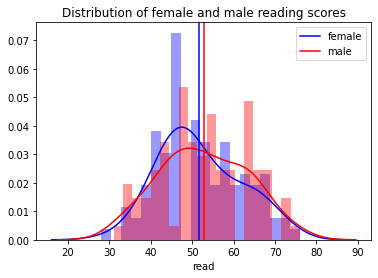

In [4]:
read_F = scores.loc[scores['female'] == 1, 'read']
read_M = scores.loc[scores['female'] == 0, 'read']

sns.distplot(read_F, color = 'blue', bins = 20, kde = True)
sns.distplot(read_M, color = 'red', bins = 20, kde = True)
plt.title('Distribution of female and male reading scores')
plt.axvline(read_F.mean(), 0, color = 'blue')
plt.axvline(read_M.mean(), 0, color = 'red')
plt.legend(labels = ['female', 'male']);

Notice that the values of the distributions of these populations overlap quite a bit and the means are close. The question is, are these differences significant?  

You can now compute the two-sample t-test to determine if the difference of means is significant. A number of summary statistics are computed and printed for the test. The two-sided t-test is used to determine if we can reject the **null hypothesis that the difference of means is not significant**.

We can try to implement the t-test manually based on what is described [in this Wikipedia article](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes,_unequal_variances_(_%7F'%22%60UNIQ--postMath-00000015-QINU%60%22'%7F_or_%7F'%22%60UNIQ--postMath-00000016-QINU%60%22'%7F)):

In [5]:
n_F, n_M = read_F.size, read_M.size
mean_F, mean_M = read_F.mean(), read_M.mean()
var_F, var_M = read_F.var(), read_M.var()
var_P = var_F / n_F + var_M / n_M

t_stat = (mean_F - mean_M) / var_P**0.5
deg_f = var_P ** 2 / ((var_F / n_F)**2 / (n_F - 1) + (var_M / n_M)**2 / (n_M - 1))
p_val = ss.t.cdf(t_stat, df = deg_f) * 2

print("statistic = {} and p-value = {}".format(t_stat, p_val))

statistic = -0.7450643492281378 and p-value = 0.45716095076827834


But instead we will use the `statsmodels` package to take care of the computation for us and present us with the results (including additional calculations such as confidence intervals):

In [6]:
def t_test(a, b, alpha = 0.05, alternative = 'two-sided', type = 'independent'):

    diff = a.mean() - b.mean()
    if type == 'independent':
        res = ss.ttest_ind(a, b, equal_var = False)
    elif type == 'paired':
        assert(len(a) == len(b))
        res = ss.ttest_rel(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha = alpha, alternative = alternative, usevar = 'unequal') 
    degfree = means.dof_satt()

    index = ['deg_of_freedom', 'observed_difference', 't-statistic', 'p_value', 'low_95_CI', 'high_95_CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

t_test(read_F, read_M)

deg_of_freedom         188.463097
observed_difference     -1.090231
t-statistic             -0.745064
p_value                  0.457161
low_95_CI               -3.976725
high_95_CI               1.796263
dtype: float64

Examine these statistics noticing the following:

1. Difference in means is small.
2. The t-statistic is small and the p-value is large. Therefore, there is a high chance that the difference in means is from random variation alone. 
3. The 95% confidence interval straddles 0.  

Based on these statistics we fail to reject the null hypothesis and conclude that the two samples came from populations with the same mean.

## Statistical power analysis

The **power of a test** is formally defined $\text{power} = P(\text{reject } H_0| \text{ when } H_0 \text{ is false})$. In plain language, the power of a test is the probability of finding a true effect to be a significant effect. A test with insufficient power will not detect a significant effect even when it should. Clearly, we want the most powerful test we can find for the situation. Computing power can be a bit complex, and analytical solutions can be difficult or impossible. Often, a simulation is used to compute power.

Let's look at the example of computation power for the two sample t-tests for the difference of means. The power of this test depends on the several parameters:

- the number of samples
- the difference in the sample means standardized by their overall variability (also known as the **effect size**)
- the significance level of the test, $\alpha$
- the type of test

When running a power test, you can ask several questions that will assist you in designing an experiment. Usually, you will determine how big a sample you need to have good chance of rejecting the null hypothesis. You can also determine how big an effect needs to be given a fixed sample size (all the samples you have or can afford) to have a good chance of rejecting the null hypothesis. 

The `statsmodels` package provides power calculations for a limited set of hypothesis tests. We can use these capabilities to examine the power. We can use it to find the right sample size for a effect size.

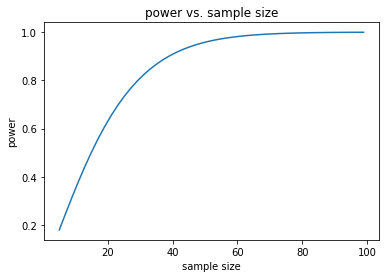

In [7]:
sample_size = np.arange(start = 5, stop = 100, step = 2)
power = [sp.tt_ind_solve_power(effect_size = abs(t_stat), nobs1 = n, alpha = 0.05, 
                               power = None, ratio = 1.0, alternative = 'two-sided') 
          for n in sample_size]


sns.lineplot(x = sample_size, y = power)
plt.title('power vs. sample size')
plt.xlabel('sample size')
plt.ylabel('power');

In practice, less than $80\%$ power for a test is not good. We can also use it to find the right effect size for a given sample size.

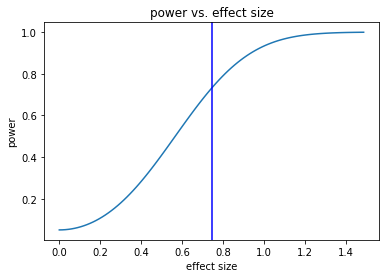

In [8]:
effect_size = np.arange(start = 0.0, stop = 1.5, step = .015)
power = [sp.tt_ind_solve_power(effect_size = x, nobs1 = 25, alpha = 0.05, 
                               power = None, ratio = 1.0, alternative = 'two-sided') 
          for x in effect_size]


sns.lineplot(x = effect_size, y = power)
plt.axvline(abs(t_stat), 0, color = 'blue') # marks the observed effect
plt.title('power vs. effect size')
plt.xlabel('effect size')
plt.ylabel('power');

Examine these results and notice how the power of the t-test rapidly increases as the difference in means increases. At a relatively small difference in means the power of the test is approaching 1.0, the maximum possible. 

### Exercise 

- Find out if there is a significant difference in reading scores between male and female students if we limit the data to public schools only: `schtyp = 1`:

- Find out if there is a significant difference between a male student's reading score and their writing score. HINT: For this you need to perform a paired t-test.

We saw that we can fail to reject the null hypothesis if the test lacks power. Let's investigate that.

- Plot 100 values for effect size ranging from $0.0$ to $1.0$ and measure the effect size required for the test.

### End of exercise

## Tests for categorical data

The t-test is used on continuous data. What if we have categorical data?

### Chi-squared tests

We use Chi-squared (also written as $\chi^2)$ tests to compare counts in different categories, where the categories are mutually exclusive.

- A Chi-squared **goodness of fit** test (also called **test of proportions** or **Pearson's Chi-squared test**) is used to test if sample is representative of population. For example, if our population is 50-50 men-women, then we test if our sample is different from those expected probabilities.
- The Chi-squared **test of independence** (also called **test of association**) tests whether two categorical variables are related to each other. It does so by comparing observed counts to counts we should expect if the two variables are independent.

The name Chi-squared comes from a corresponding probability distribution. It's density depends on a parameter we call **degrees of freedom**, which is greater the bigger the sample size.

![](https://library.startlearninglabs.uw.edu/DATASCI410/img/Chi-square.png)

As with any probability density function, confidence intervals and p-values can be computed. Notice that the $\chi$-squared distribution becomes flatter and with greater dispersion as the degrees of freedom increase. In practice, this means that you will need large samples to get a meaningful result if you have too many choices in your test.

#### Chi-squared test of proportion example

Here's an example of the Chi-squared goodness of fit: The traditional way to apply a chi-squared test is to first create a chi-squared table. In this example we are looking the results of an A-B test with three possible outcomes. This type of test might be applied to determine if a new web site drives more customer purchases.

The code in the cell below builds a simple chi-squared table. The data we have are

- actual occurrence of events
- expected probability of these events (based on the distribution of the null hypothesis)

From the above data we then calculate the following

- the expected occurrence of events given the expected probabilities
- the difference between the occurrence and the expected number of events
- the square of the difference
- the squared difference normalized by the expected number of occurrences

The sum of the figures in the last column is the Chi-squared statistic. In other words 

$$\chi^2_{\text{statistic}} = \sum_{i = 1}^k \frac{(o_i - e_i)^2}{e_i}$$ 

where we have $k$ groups, $o_i$ is the observed count for group $i$ and $e_i$ is the expected count for group $i$ based on the hypothesized proportions. Under $H_0$ we assume $\chi^2_{\text{statistic}} \sim \chi^2(k-1)$ where $k-1$ are the degrees of freedom.

Let's say for example that the national proportions for socio-economic status (column `ses` with mapping 1:low, 2:middle, and 3:high) is 30 percent for low, 60 percent for middle and 10 percent for high. Here are the counts we observe in the data:

In [9]:
ses_national = [0.3, 0.6, 0.1]
ses_counts = scores['ses'].value_counts(sort = False)
ses_counts

1    47
2    95
3    58
Name: ses, dtype: int64

We can manually compute the $\chi^2$ statistic as such:

In [10]:
ses_data = pd.DataFrame({'ses': ['low', 'middle', 'high'],
                         'observed_count': ses_counts,
                         'hypothesized_proportion': ses_national})

total_count = ses_data['observed_count'].sum()
ses_data['expected_count'] = total_count * ses_data['hypothesized_proportion']

ses_data['diff_squared'] = (ses_data['observed_count'] - ses_data['expected_count'])**2
ses_data['diff_normalized'] = ses_data['diff_squared'] / ses_data['expected_count']

chi_squared_statistic = ses_data['diff_normalized'].sum()
print("chi_squared_statistic = {}".format(chi_squared_statistic))
ses_data

chi_squared_statistic = 80.22500000000001


,ses,observed_count,hypothesized_proportion,expected_count,diff_squared,diff_normalized
1,low,47,0.3,60.0,169.0,2.816667
2,middle,95,0.6,120.0,625.0,5.208333
3,high,58,0.1,20.0,1444.0,72.200000


The $\chi$-squared test statistic we calculated is 13.708. We have $3-1 = 2$ degrees of freedom for the $\chi^2$ distribution. We can get a p-value for this statistic now:

In [11]:
1 - ss.chi2.cdf(13.7, df = 2)

0.0010594556929076626

This p-value is rather small, so we reject the null hypothesis. In other words, assuming the hypothesized proportions for each group, there is little chance that the differences between the observed and expected occurrences are the result of random variation alone.

In the foregoing example we computed the chi-squared statistic and p-value directly. In general, this is a somewhat cumbersome approach. Instead, we can use the `chisquare` function from the `scipy.stats` package as shown in the code below.

In [12]:
chi_sq_stat, p_value = ss.chisquare(ses_data['observed_count'], ses_data['expected_count'])
print('Chi-squared statistic = {} and p-value = {}.'.format(str(chi_sq_stat), str(p_value)))

Chi-squared statistic = 80.22500000000001 and p-value = 3.7963180921057184e-18.


Finally, we should check the power of our test. First we compute our observed effect size:

In [13]:
eff_size = statsmodels.stats.gof.chisquare_effectsize(ses_counts / ses_counts.sum(), ses_national)
eff_size

0.41875555980434487

We can see where we are by plotting effect size against power:

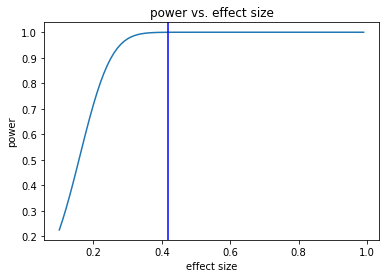

In [14]:
effect_size = np.arange(start = 0.1, stop = 1.0, step = 0.01)
power = sp.GofChisquarePower().solve_power(effect_size = effect_size, nobs = ses_counts.sum(), 
                                           n_bins = 3, alpha = 0.05)

sns.lineplot(x = effect_size, y = power)
plt.axvline(abs(eff_size), 0, color = 'blue') # marks the observed effect
plt.title('power vs. effect size')
plt.xlabel('effect size')
plt.ylabel('power');

Apparently, this test is quite powerful, and we could have detected much smaller differences between the observed and expected counts.

Let's perform a Chi-squared test of independence to see if two categorical variables are related or not. We use race and school type (private or public) here:

In [15]:
ct = pd.crosstab(scores['race'], scores['schtyp'])

In [16]:
chi_sq_stat, p_value, dof, ct_expected = ss.chi2_contingency(ct)
print('Chi-squared statistic = {} and p-value = {}.'.format(str(chi_sq_stat), str(p_value)))

Chi-squared statistic = 2.7169789023237296 and p-value = 0.437349615000054.


We can also calculate the effect size by flattening the observed and expected counts tables and turning counts into percentages.

In [ ]:
obs = ct.values.ravel() / ct.values.sum()
exp = ct_expected.ravel() / ct_expected.sum()

eff_size = statsmodels.stats.gof.chisquare_effectsize(obs, exp)
eff_size

If we return to the chart of power vs effect size we would see that this test has low power.

## Testing distributions

Tests of hypothesis often make distributional assumptions. This raises the question of how can we test if our data fits some distribution. To answer this question we will now look at both graphical and formal tests. Since in most cases, distribution assumptions are approximate, simple graphical methods are often sufficient.

### The Q-Q plot

The quantile-quantile (Q-Q) plot provides a handy visual means to inspect the similarity of distributions of a data set. The general idea is to plot the quantiles of the sample on the vertical axis and the quantiles of the theoretical distribution on the horizontal axis. If the points of the plot fall on an approximately straight line, you can conclude that the sample distribution is close to the theoretical. 

The normal Q-Q plot plots the quantiles of a standard normal distribution on the horizontal axis and the quantiles of the data sample on the vertical axis. If the sample is normal the data points will fall in a straight line. 

Run the code in the cell below to create Q-Q plots of the two samples, and examine the results.

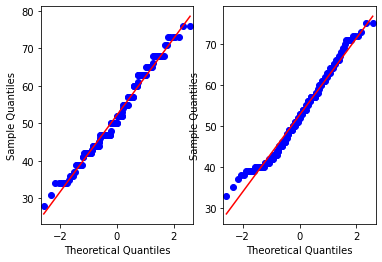

In [18]:
fig, axs = plt.subplots(ncols = 2)
sm.qqplot(scores['read'], line = 's', ax = axs[0])
sm.qqplot(scores['math'], line = 's', ax = axs[1]);

The line of points on both Q-Q plots is close to straight, showing the not surprising result given that both samples are realizations of the normal distribution.

We can also visualize the **cumulative density functions** (CDFs) of the two samples.

In [17]:
def plot_cums(dist1, dist2, labels = ['sample 1', 'sample 2']):
    plt.figure(figsize = (10, 6))
    p = np.arange(len(dist1)) / (len(dist1) - 1) # calculate the proportional values of samples

    data_sorted = np.sort(dist1) # sort the first data sample
    sns.lineplot(x = data_sorted, y = p)
    
    data_sorted = np.sort(dist2) # sort the seond data sample:
    sns.lineplot(x = data_sorted, y = p)

    plt.title('empirical CDFs of two datasets')
    plt.xlabel('range of data')
    plt.ylabel('percentile')
    plt.legend(labels = labels)

    return None

In [ ]:
plot_cums(scores['read'], scores['math'], labels = ['reading', 'math'])

Note that since math and reading scores are on the same scale we didn't need to rescale the data, but in general we need to rescale the data prior to comparing the distributions.

In [ ]:
read_norm = (scores['read'] - scores['read'].mean()) / scores['read'].std()
math_norm = (scores['math'] - scores['math'].mean()) / scores['math'].std()

plot_cums(read_norm, math_norm, labels = ['reading', 'math'])

Notice that, as you might expect, the two CDFs are quite similar, indicating that the two samples are drawn from the same distribution. But are the deviations significant? We can answer that more formally using the **Kolmogorov-Smirnov test**.

### The Kolmogorov-Smirnov test

We can test whether a sample follows a theoretical distribution or if two distributions are significantly different by using the Kolmogorov-Smirnov test. The K-S statistic is just the maximum vertical distance between the CDF of the sample and the CDF of the theoretical distribution, or the CDFs of two independent samples. Since it is based on a simple deviation, the K-S test can test departure from any hypothetical distribution, not just normal.

The **K-S statistic is the maximum vertical difference** between the two cumulative density functions. Based on this distance and the number of samples, the p-value for the K-S test is computed. It is important that the **samples must be standardized** before applying the K-S test.

In [ ]:
ss.kstest(read_norm, 'norm')

The p-value is small, therefore fail to reject the null hypothesis that the data is normally distributed (with $\mu = 0$ and $\sigma = 1$). In other words, assuming that the data is normally distributed, a sample like ours is quite unusual.

Now, we and test if the sample appears to be drawn from the t distribution (using $5$ degrees of freedom so as to give it heavier tails).

In [ ]:
ss.kstest(read_norm, 't', (5,))

In this case, we cannot reject the null hypothesis that these distributions are different. The K-S statistic is small and the p-value is large.  

The K-S test is rather general, as it can be applied to test any distribution. However, this means that the **power** of this test is limited. The power of a test is the probability of rejecting a null hypothesis when the alternative is true. 

As is always the case with classical statistics, a more powerful test can be created by adopting more restrictive assumptions. For example, the Shapiro-Wilk test has greater power, but is specifically for normal distributions. 

## Testing multiple groups with ANOVA

So far, we have only looked at tests for comparing two samples. What if we have multiple groups and we wanted to compare their means? Why can’t we just do multiple two-sample t-tests for all pairs? Because doing so results in increased probability of accepting a false hypothesis; e.g., if we had 7 groups, there would be $7 \choose 2$ $=21$ pairs to test.  Recall that the $\alpha$ cutoff is the probability of committing a type-I error, so if $\alpha = 0.05$ for any one test then we have a 95% probability of rejecting $H_0$ correctly. But this probability drops as we perform more tests: for 21 tests it is $0.95^{21} \approx 0.34$!

This problem is known as the problem of **multiple comparisons** or **base rate fallacy**. With large numbers of groups, there is a high probability of getting a false positive (type I error). Several adjustments to the multiple comparisons problem have been proposed, such as the **Bonferroni correction**: instead of $\alpha$ we use $\alpha_b = \frac{\alpha}{k}$ (where $k$ is the number of groups) as our p-value threshold. This tends to be a conservative approach that won't work well if $k$ is very high. There are other approaches that we won't get into here.

Instead of trying to find out all possible significant effects like we do above, we can first perform a test to see if there are *any* significant effects, without necessarily knowing which:

- Null hypothesis: All groups are samples from the same population.
- Alternative hypothesis: At least one group has a statistically different mean.

This type of analysis is called “ANalysis Of VAriance”, or ANOVA for short. ANOVA is one of a large family of models used for **experimental design**.

Let's have a look at how we would perform the comparisons between the multiple groups of data. First, make data independence and normality assumptions about the groups. Let $k$ be the number of treatment groups, $n$ be the number of data points and SS be the sum of squares. We can split total sum of squares **SSTotal** into the sum of squared errors *between* treatments **SST** and the sum of squared errors *within* treatments **SSE**: SSTotal = SST + SSE. We can divide each by its corresponding degrees of freedom to get the mean squared error between treatments **MST** and the mean square error within treatments **MSE**. Finally we can compute the F-statistic and derive the p-value by referring to the [F distribution](https://en.wikipedia.org/wiki/F-distribution). 

We leave out the details of the exact calculations, and instead we summarize the results in an ANOVA table as follows:

|Type|Sum of Squares|degrees of freedom|Mean Square E|F|Significance|
|---|:---:|:---:|:---:|:---:|:---:|
|between groups|SST|$k-1$|SST / $k-1$|F-statistic| p-value|
|within groups|SSE|$n-k$|SSE / $n-k$|||
|total|SSTotal|$n-1$||||

Let's now see an example. Let's say we wanted to test if on average the social studies scores are different for students with different socio-economic backgrounds.

In [1]:
sns.boxplot(x = 'ses', y = 'socst', data = scores);

NameError: name 'sns' is not defined

The plot shows variation between the distributions of the groups, but are any of these differences significant? To answer that we use an ANOVA test:

In [ ]:
model = ols('socst ~ C(ses)', data = scores).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

The F statistic is fairly large and the p-value is small. So we reject the null hypothesis and conclude that there are significant differences between the different groups.

Note that ANOVA isn't just a test, but also a statistical model. This means that once we fit it to the data, we can then use it to obtain predictions:

In [ ]:
model.predict({'ses': [1, 2, 3]}) # we get a unique prediction for each value of ses

In [ ]:
scores['socst_pred'] = model.predict(scores)
scores.head()

Let's draw the distribution (histogram) of the actual scores vs predicted scores for social studies.

In [ ]:
sns.distplot(scores['socst'], kde = False, bins = 25, color = 'blue')
sns.distplot(scores['socst_pred'], kde = False, bins = 25, color = 'red');

We can see that the predicted scores are less varied than the actual scores. In fact, the model predicts only three distinct scores. This should not come as a surprise, since we trained a model to predict social studies score using **only** socio-economic status `ses` (ignoring all the other variables). So this model is returning a unique score for each socio-economic group. We can make this model richer by adding more variables to it, but that's the topic of another lecture.

### Tukey's multiple comparison test

From the above ANOVA results we know that there is some difference in the means of these groups. However, ANOVA does not tell us which pairs of groups are significantly different from each other. From the box plot, we could make an educated guess, but one formal way of comparing groups is using **Tukey's multiple comparison** test. The test returns the following for each pairing of groups:

- the difference of the means
- the confidence interval of the difference in the means
- the p-value from the distribution of the differences

These results are laid out in a table or can be plotted graphically. Only differences in means with a confidence interval not overlapping zero are considered significant.

In [ ]:
Tukey_HSD = pairwise_tukeyhsd(scores['socst'], scores['ses'])
print(Tukey_HSD)

Examine the table above. If the difference in means between the variables is significant, the confidence interval will not include 0. Which, pairs have a significant difference at the 95% confidence level? You can see the results of this test in the left most column of the table.

## Summary

We have covered some examples of statistical tests in this lesson. Since there are many more tests than what we covered, we also saw how to more broadly categorize tests and what elements to look for when learning about a statistical test.

## Supplementary Material

If you need some review of the concepts of classical statistics there are numerous good books available. Two particularly non-mathematical and readable books are shown below. These books have distinct and different styles. If you do not like one, you might like the other. Or, you may benefit from reading both. 

<img src="https://library.startlearninglabs.uw.edu/DATASCI410/img/StatsDoneWrong.jpg" title="Reinhart, 2015" alt="Reinhart's book" style="float: left; height: 200px; margin-right: 10px;"/><img src="https://library.startlearninglabs.uw.edu/DATASCI410/img/p-value.jpg" title="Vicker, 2009" alt="Vicker's book" Style="float: right; height: 200px; margin-left: 10px;" />
Alex Reinhart's book, *Statistics Done Wrong, a woefully complete guide*, No Starch Press, 2015, discusses classical statistical tests using numerous clever examples. 

Andrew Vicker's *What is a P-Value Anyway*, Pearson, 2009, is perhaps the most humorous statistics book ever written; admittedly a category with little competition. The treatment is a bit broader than Reinhart's book. 


